In [39]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import pandas as pd
import matplotlib.tri as tri
import csv
import sys
import os
import pandas

def plot_spectrum(s,cadence):
    f = np.fft.rfftfreq(len(s))
    plt.loglog(1/f * cadence, np.abs(np.fft.rfft(s)),'.') #mult times cadence
    plt.xlabel("Timescale in days") ## for 1/f
    plt.ylabel("Power Coefficient")
def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N)); 
        S = psd(np.fft.rfftfreq(N))
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1;

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f):
    return f;

psd_noise_std = .0041 # Why Did i do this??

v_noise = violet_noise(2**14)
v_noise=[point * psd_noise_std + 1 for point in v_noise] #adjusting for error

blue_noise = blue_noise(2**14)
blue_noise=[point * psd_noise_std + 1 for point in blue_noise] #adjusting for error


pink_noise=pink_noise(2**14)
pink_noise=[point * psd_noise_std + 1 for point in pink_noise] #adjusting for error

white_noise=white_noise(2**14)
white_noise=[point * psd_noise_std + 1 for point in white_noise] #adjusting for error



In [40]:
def plot_simulated(simulated_noise_type):

    #Plotting lightcurve
    k =np.vstack((simulated_noise_type,np.arange(0,len(white_noise),1)))
    time=k[1,:]
    flux=k[0,:]

    plt.scatter(time,flux, s=5)
    plt.show()


    #Plotting power spectrum
    #plt.title((str(simulated_noise_type)+ 'PSD'))
    cadence = time[1] - time[0]
    print(cadence)
    plot_spectrum(simulated_noise_type,cadence)
    plt.show()


    #Plotting sigma comparison
    binsizes = (1, 2, 10, 100, 500, 1000, 2000)
    binned_sigma = []

    for binsize in binsizes:
        nbins = len(flux) / binsize
        np.floor(len(flux)*(binsize))
        means = np.zeros(int(nbins))
        for i in range (0, int(nbins)):

            fluxpiece = flux[int((i*binsize)):int((((i+1)*binsize)))]
            means[i]= np.average(fluxpiece)

        std_means = np.std(means)
        binned_sigma.append(std_means)
    print(binned_sigma)


    std = np.std(flux)
    ideal_sigma_1 = std
    ideal_sigma_2 = std / (2 ** (1/2))
    ideal_sigma_10 = std / (10 ** (1/2))
    ideal_sigma_100 = std / (100 ** (1/2))
    ideal_sigma_500 = std / (500 ** (1/2))
    ideal_sigma_1000 = std / (1000 ** (1/2))
    ideal_sigma_2000 = std / (2000 ** (1/2))
    ideal_sigmas = np.array([ideal_sigma_1, ideal_sigma_2, ideal_sigma_10, ideal_sigma_100, ideal_sigma_500, ideal_sigma_1000, ideal_sigma_2000])




    plt.xlabel("N value")
    plt.ylabel("Sigma")
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(binsizes, ideal_sigmas)
    plt.plot(binsizes,binned_sigma)
    #blue is unbinned white noise #y axis is sigma/sqrt(n) or sigma_bin #x axis is bin size

In [41]:
def plot_TESS(tesscurve):
    
    #normalizing tesscurve
    ttv = lk.search_lightcurve(str(tesscurve), cadence = "short").download_all(quality_bitmask='hard')
    lc=ttv[0].flatten().to_pandas()
    lc.reset_index(inplace=True)
    flux= lc["flux"]
    time = lc["time"] #time starts at >1000
    time_start_0 = [value - time[0] for value in time] #make time start at 0

    list_of_tuples = list(zip(time_start_0, flux))

    df = pd.DataFrame(list_of_tuples, columns=['Time', 'Flux'])
    df.to_csv(str(tesscurve) + '.csv', index=False)
    
    #plotting lightcurve
    plt.scatter(time_start_0,flux, s = 5)
    plt.show()

    #plotting power spectrum
    cadence = time[1]-time[0]
    plot_spectrum(flux,cadence) #plot as a line 1/frequencies # blue
    plt.show()

    print("cadence in days: " , cadence)
    print("Tess data len: " , len(flux))
    print("Standard dev: " , np.std(flux))


    #TESS noise sigma comparison


    #sigma is the standard deviation of the means of a bin given a bin size
    binsizes = (1, 2, 10, 100, 500, 1000, 2000)
    binned_sigma = []

    for binsize in binsizes:
        nbins = len(flux) / binsize
        np.floor(len(flux)*(binsize))
        means = np.zeros(int(nbins))
        for i in range (0, int(nbins)):

            fluxpiece = flux[int((i*binsize)):int((((i+1)*binsize)))]
            means[i]= np.average(fluxpiece)

        std_means = np.std(means)
        binned_sigma.append(std_means)
    print('binned_sigmas' +str(binned_sigma))


    std = np.std(flux)
    ideal_sigma_1 = std
    ideal_sigma_2 = std / (2 ** (1/2))
    ideal_sigma_10 = std / (10 ** (1/2))
    ideal_sigma_100 = std / (100 ** (1/2))
    ideal_sigma_500 = std / (500 ** (1/2))
    ideal_sigma_1000 = std / (1000 ** (1/2))
    ideal_sigma_2000 = std / (2000 ** (1/2))
    ideal_sigmas = np.array([ideal_sigma_1, ideal_sigma_2, ideal_sigma_10, ideal_sigma_100, ideal_sigma_500, ideal_sigma_1000, ideal_sigma_2000])
    print('ideal_sigmas' + str(ideal_sigmas))



    plt.xlabel("N value")
    plt.ylabel("Sigma")
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(binsizes, ideal_sigmas)
    plt.plot(binsizes,binned_sigma)

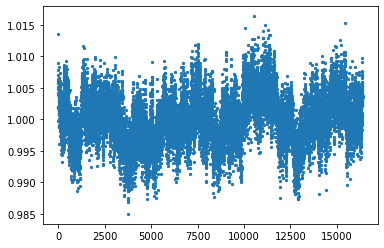

1.0


/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_1979/669838812.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f * cadence, np.abs(np.fft.rfft(s)),'.') #mult times cadence


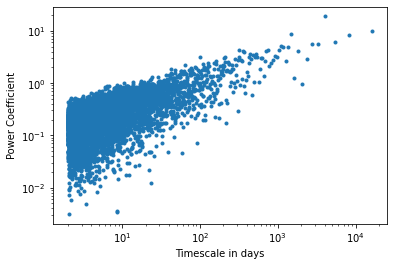

[0.004105963647460313, 0.003925300793859781, 0.0035289815030495725, 0.002897954839948651, 0.002362535987449255, 0.0019649785763060815, 0.0017493642049456538]


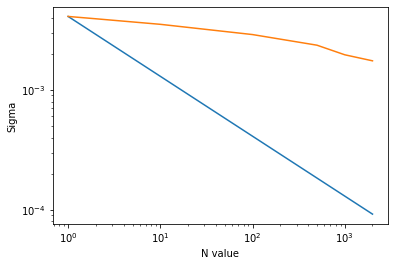

In [42]:
plot_simulated(pink_noise)

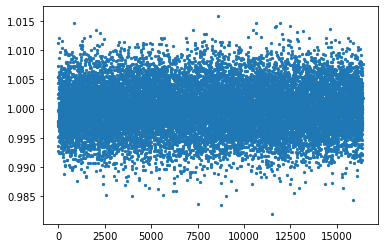

1.0


/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_1979/669838812.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f * cadence, np.abs(np.fft.rfft(s)),'.') #mult times cadence


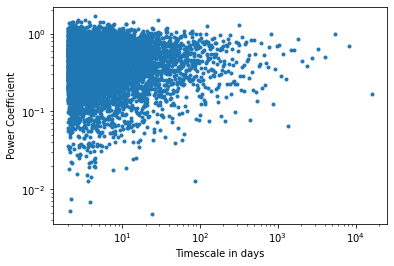

[0.004112362143453375, 0.0028960985864778283, 0.0012923113093082131, 0.0004017658161059086, 0.00020505402697955683, 0.00015711773533586167, 0.0001070836651967234]


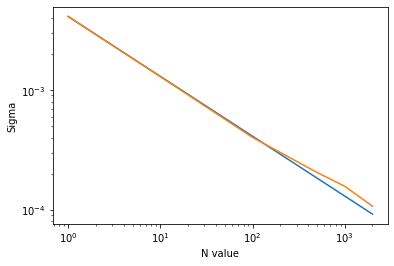

In [43]:
plot_simulated(white_noise)

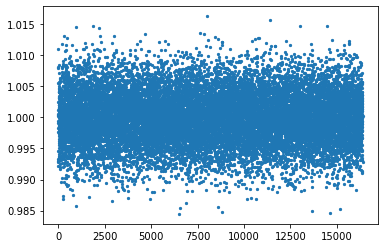

1.0


/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_1979/669838812.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f * cadence, np.abs(np.fft.rfft(s)),'.') #mult times cadence


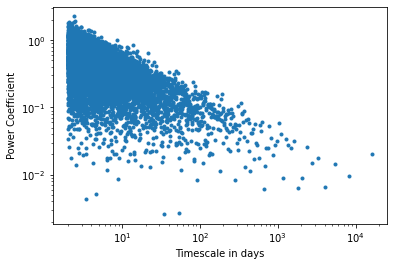

[0.004105612382933316, 0.0022374526426737758, 0.0005665509247926411, 6.715450669270239e-05, 1.2377978153356847e-05, 6.934650553848578e-06, 3.711985824646482e-06]


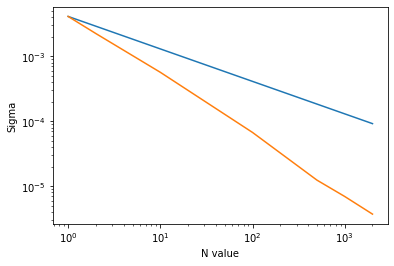

In [44]:
plot_simulated(blue_noise)

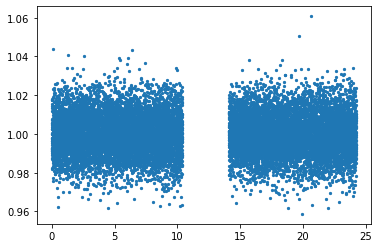

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_1979/669838812.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f * cadence, np.abs(np.fft.rfft(s)),'.') #mult times cadence


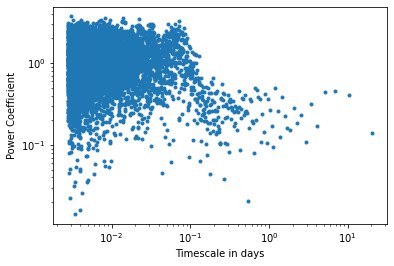

cadence in days:  0.0013889325205127534
Tess data len:  14759
Standard dev:  0.010669393070550186
binned_sigmas[0.010669393070550174, 0.007540697419641748, 0.0031237340934240415, 0.0003755273331555615, 0.00012495156043433272, 9.143328101087171e-05, 6.975539920487536e-05]
ideal_sigmas[0.01066939 0.0075444  0.00337396 0.00106694 0.00047715 0.0003374
 0.00023857]


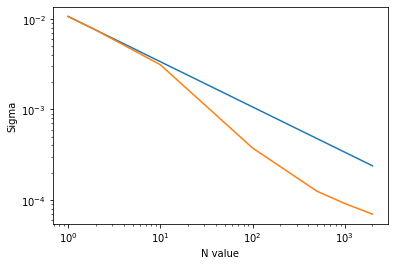

In [46]:
plot_TESS('TIC 616545501')

          Time      Flux
0     0.000000  0.999969
1     0.000681  0.999861
2     0.001362  1.000211
3     0.002043  0.999578
4     0.002725  1.000342
...        ...       ...
1995  1.415413  1.000171
1996  1.416094  0.999609
1997  1.416775  0.999934
1998  1.417456  0.999860
1999  1.418137  0.999840

[2000 rows x 2 columns]


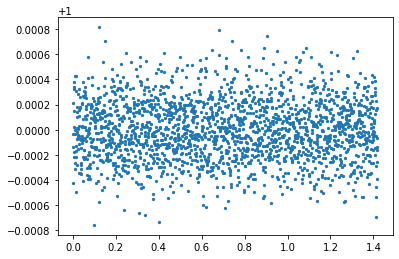

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_1979/669838812.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f * cadence, np.abs(np.fft.rfft(s)),'.') #mult times cadence


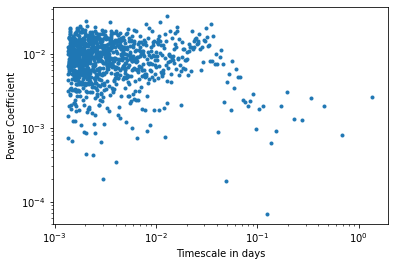

cadence in days:  0.0006811218845541
Tess data len:  2000
Standard dev:  0.00023915408763789512
binned_sigmas[0.00023915408763789512, 0.00017251964984283828, 0.00012063371086991043, 8.365933264554484e-05, 4.918449460111672e-05, 2.285112611171193e-05, 1.0491734196216268e-05, 6.979530401998916e-06, 4.467246859534306e-06]
ideal_sigmas[2.39154088e-04 1.69107477e-04 1.19577044e-04 8.45537386e-05
 5.97885219e-05 4.22768693e-05 2.98942610e-05 2.11384346e-05
 1.49471305e-05]
Kepler-1


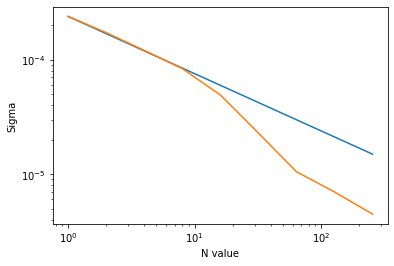

In [51]:
#KEPLER DATA

#normalizing tesscurve
dataset = pd.read_csv('Kepler-1.csv')
time = dataset.iloc[:, 0].values
flux = dataset.iloc[:,1].values
print(dataset)
time_start_0 = time#[value - time[0] for value in time] #make time start at 0

#plotting lightcurve
plt.scatter(time_start_0,flux, s = 5)
plt.show()

#plotting power spectrum
cadence = time[1]-time[0]
plot_spectrum(flux,cadence) #plot as a line 1/frequencies # blue
plt.show()

print("cadence in days: " , cadence)
print("Tess data len: " , len(flux))
print("Standard dev: " , np.std(flux))


#TESS noise sigma comparison


#sigma is the standard deviation of the means of a bin given a bin size
binsizes = (1, 2, 4, 8, 16, 32, 64, 128, 256)
binned_sigma = []

for binsize in binsizes:
    nbins = len(flux) / binsize # if the binsize is n long, then nbins is the length of flux divided by n binsize
    np.floor(len(flux)*(binsize))
    means = np.zeros(int(nbins))
    for i in range (0, int(nbins)):

        fluxpiece = flux[int((i*binsize)):int((i+1)*binsize)]
        means[i]= np.average(fluxpiece)

    std_means = np.std(means)
    binned_sigma.append(std_means)
print('binned_sigmas' +str(binned_sigma))


std = np.std(flux)
ideal_sigma_1 = std / (1 **(1/2))
ideal_sigma_2 = std / (2 ** (1/2))
ideal_sigma_4 = std / (4 ** (1/2))
ideal_sigma_8 = std / (8 ** (1/2))
ideal_sigma_16 = std / (16 ** (1/2))
ideal_sigma_32 = std / (32 ** (1/2))
ideal_sigma_64 = std / (64 ** (1/2))
ideal_sigma_128 = std / (128 ** (1/2))
ideal_sigma_256 = std / (256 ** (1/2))

ideal_sigmas = np.array([ideal_sigma_1, ideal_sigma_2, ideal_sigma_4, ideal_sigma_8, ideal_sigma_16, ideal_sigma_32, ideal_sigma_64, ideal_sigma_128, ideal_sigma_256])
print('ideal_sigmas' + str(ideal_sigmas))


print('Kepler-1')
plt.xlabel("N value")
plt.ylabel("Sigma")
plt.xscale("log")
plt.yscale("log")
plt.xlim()
plt.plot(binsizes, ideal_sigmas)
plt.plot(binsizes,binned_sigma)